In [1]:
import torch
import torch.nn.functional as F
from helpers import char_to_int_map, int_to_char_map, build_dataset, split

In [6]:
words = open("names.txt").read().splitlines()

In [7]:

ctoi = char_to_int_map(start_char='.')
itoc = int_to_char_map(ctoi)
num_c = len(ctoi)
X, Y = build_dataset(words, ctoi, 3) 

In [8]:
encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()

In [9]:
# layer 1
C = torch.rand((num_c, 2))

In [10]:
emb = encoder(X) @ C

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_40959/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


In [11]:
# layer 2
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [12]:
h = emb.view(-1, 6) @ W1 + b1 # set to - 1 as pytorch can infer it's dim 

In [13]:
activation = lambda layer: torch.tanh(layer)

In [14]:
layer_1_out = activation(h)

In [15]:
# decoder layer
W2 = torch.randn((100, num_c))
b2 = torch.randn(num_c)

In [16]:
logits = layer_1_out @ W2 + b2

In [17]:
logits.shape

torch.Size([228146, 27])

In [18]:
 # softmax
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)

In [19]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()

In [20]:
def MLP_tune_learning_rate(X, Y, num_c, batch_size, lre, lrs, steps=100):
    token_size = X.shape[1]
    g = torch.Generator().manual_seed(1)
    C = torch.randn((num_c, 2), generator=g)
    W1 = torch.randn((2*token_size, 100), generator=g)
    b1 = torch.randn(100, generator=g)
    W2 = torch.randn((100, num_c), generator=g)
    b2 = torch.randn(num_c, generator=g)
    
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
        
    lri = []
    lossi = []
    
    for i in range(steps):
        lr = lrs[i]
        # make minibatch
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)

        # forward pass
        emb = X[ix] @ C # X here is X encoded, but since it's one hot encoded, you can also do C[X] where X is the non-encoded tensor of inputs
        l1 = emb.view((-1, token_size*C.shape[1])) @ W1 + b1
        h = activation(l1) 
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])
        # backwards pass
        for p in parameters:
            p.grad = None
        loss.backward()
        for p in parameters:
            p.data += -lr * p.grad
            
        lri.append(lre[i])
        lossi.append(loss.item())
        
    return loss.item(), lri, lossi
    
encx = encoder(X)
ency = encoder(Y)
batch_size = 32
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
steps = 1000
loss, lri, lossi = MLP_tune_learning_rate(encx, ency, num_c, batch_size, lre, lrs, steps)
print(loss)

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_40959/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


8.430161476135254


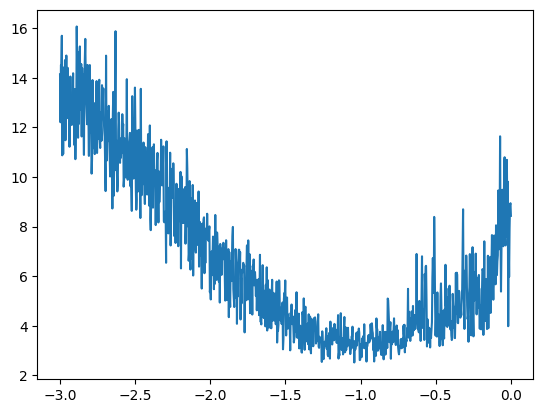

In [21]:
import matplotlib.pyplot as plt
plt.plot(lri, lossi)
# here we are plotting the exponent of the learning rate

In [22]:
def MLP(X, Y, parameters, batch_size, lr, steps=100, print_break=5000):
    token_size = X.shape[1]
    
    C, W1, b1, W2, b2 = parameters
    
    for p in parameters:
        p.requires_grad = True
    lossi = []
    for i in range(steps):
        # make minibatch
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)

        # forward pass
        emb = X[ix] @ C # X here is X encoded, but since it's one hot encoded, you can also do C[X] where X is the non-encoded tensor of inputs
        l1 = emb.view((-1, token_size*C.shape[1])) @ W1 + b1 
        h = activation(l1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])
        # backwards pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        for p in parameters:
            p.data += -lr * p.grad
        
        lossi.append(loss)
        if i % print_break == 0:
            print(f"loss at {i}/{steps}: ", loss.item())
    return loss.item(), lossi


In [23]:
encx = encoder(X)
ency = encoder(Y)
batch_size = 32
lr = 10**-1
steps = 1
g = torch.Generator().manual_seed(1)
C = torch.randn((num_c, 2), generator=g)
W1 = torch.randn((2*X.shape[1], 100), generator=g) * 0.1
b1 = torch.randn(100, generator=g) * 0.01
W2 = torch.randn((100, num_c), generator=g) * 0.01
b2 = torch.randn(num_c, generator=g) * 0 
parameters = [C, W1, b1, W2, b2]

loss, _ = MLP(encx, ency, parameters, batch_size, lr, steps)
print(loss)


loss at 0/1:  3.2970378398895264
3.2970378398895264


/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_40959/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


In [24]:
W1_no_scale = torch.randn((2*X.shape[1], 100), generator=g)
b1_no_scale = torch.randn(100, generator=g)
emb = encx[:40] @ C
hlayer_no_scale = emb.view((-1, W1_no_scale.shape[0])) @ W1_no_scale + b1_no_scale

In [25]:
W1_scaled = W1_no_scale * 0.1
b1_scaled = b1_no_scale * 0.01
emb = encx[:40] @ C
hlayer_scaled = emb.view((-1, W1_scaled.shape[0])) @ W1_scaled + b1_scaled


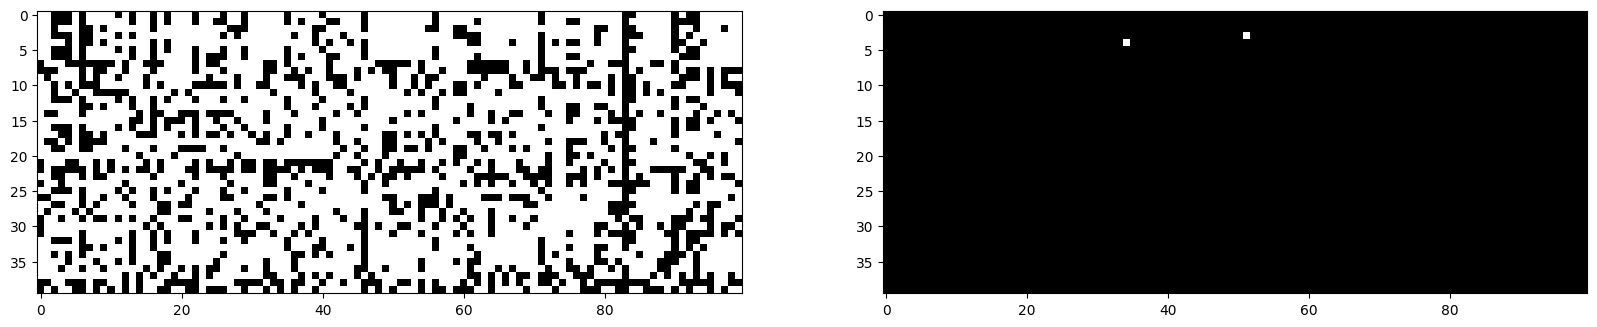

In [26]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(hlayer_no_scale.abs() > 0.99, cmap='gray',interpolation='nearest')
plt.subplot(122)
# plt.figure(figsize=(10, 5))
plt.imshow(hlayer_scaled.abs() > 0.99, cmap='gray',interpolation='nearest')

What we see above is white squares represent all the neurons that are going to be wiped out by the tanh activation since they lie at the tail ends which effectively leads to no change in the gradient, so the neuron is basically dead.
This is caused by the randomized weights in W1 being way to big, and causing the embedding to range between super large numbers. When you then feed that to a tanh layer, you see that the dist of values is concentrated at -1 or 1, which, when used to calculate the update, causes the change in gradient to be negligible. 

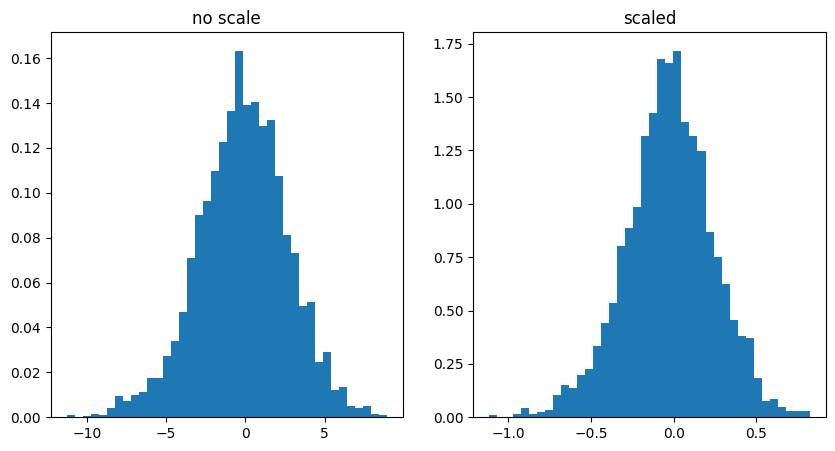

In [35]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("no scale")
plt.hist(hlayer_no_scale.view(-1).tolist(), hlayer_no_scale.shape[0], density=True)
plt.subplot(122)
plt.title("scaled")
plt.hist(hlayer_scaled.view(-1).tolist(), hlayer_scaled.shape[0], density=True)
plt.show()


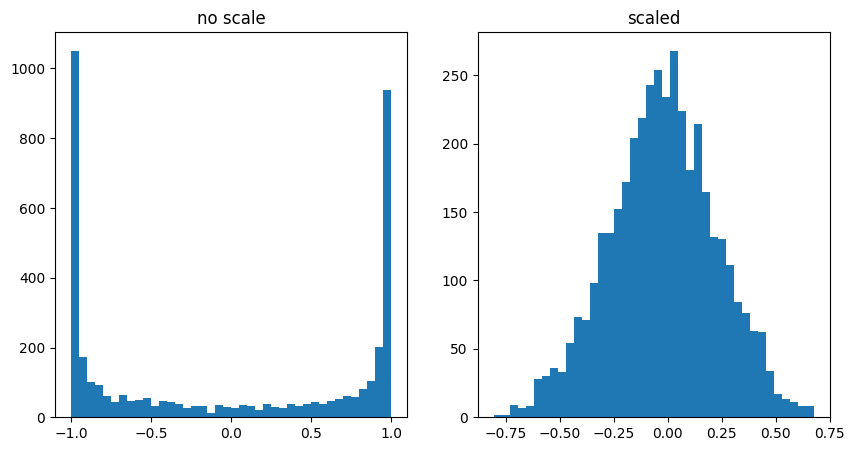

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("no scale")
activated_no_scale = activation(hlayer_no_scale)
plt.hist(activated_no_scale.view(-1).tolist(), activated_no_scale.shape[0])
plt.subplot(122)
plt.title("scaled")
activated_no_scale = activation(hlayer_scaled)
plt.hist(activated_no_scale.view(-1).tolist(), activated_no_scale.shape[0])
plt.show()

We can see from this that the neurons will be a lot more active and the gradients won't start off getting so washed out in that first layer due to this more normal (guassian) distribution. Having this kind of distribution allows for more activations to actually have an effect from the start of training.

# Now with train, val, test

In [30]:
def forward_pass(X, Y, parameters):
    C, W1, b1, W2, b2 = parameters
    
    for p in parameters:
        p.requires_grad = True
    
    emb = X @ C
    h = emb.view((-1, W1.shape[0])) @ W1 + b1
    l1 = activation(h)
    logits = l1 @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

def runMLP(encx_train, encx_val, ency_train, ency_val, num_c):
    batch_size = 32
    lr = 10**-1
    steps = 100000
    emb_layer_size = 10
    tanh_layer_size = 200
    g = torch.Generator().manual_seed(1)
    C = torch.randn((num_c, emb_layer_size), generator=g)
    W1 = torch.randn((emb_layer_size*encx_train.shape[1], tanh_layer_size), generator=g) * (5/3) /  ((emb_layer_size*encx_train.shape[1])**0.5) # this is basically a kaiming init done manually
    b1 = torch.randn(tanh_layer_size, generator=g) * 0.01
    W2 = torch.randn((tanh_layer_size, num_c), generator=g) * 0.01  # we want the output in the initial stage to be close to uniform, since all outputs should have an equal chance 
    b2 = torch.randn(num_c, generator=g) * 0 # we want the output in the initial stage to be close to uniform, since all outputs should have an equal chance 
    parameters = [C, W1, b1, W2, b2]
    training_loss, training_lossi = MLP(encx_train, ency_train, parameters, batch_size, lr, steps, print_break=20000)
    print("training loss: ", training_loss)
    # the parameters are passed by reference, which is why they get changed and we don't have to pass them back
    val_loss = forward_pass(encx_val, ency_val, parameters)
    print("val loss: ", val_loss)
    return parameters, training_lossi
    
encx = encoder(X)
ency = encoder(Y)
encx_train, encx_val, encx_test  = split(encx, [0.8,0.1,0.1])
ency_train, ency_val, ency_test = split(ency, [0.8,0.1,0.1])
parameters, training_lossi = runMLP(encx_train, encx_val, ency_train, ency_val, num_c)

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_40959/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


loss at 0/100000:  3.2854385375976562
loss at 20000/100000:  2.1177728176116943
loss at 40000/100000:  1.9143339395523071
loss at 60000/100000:  2.745445489883423
loss at 80000/100000:  2.0615694522857666
training loss:  2.129481315612793
val loss:  2.4165842533111572


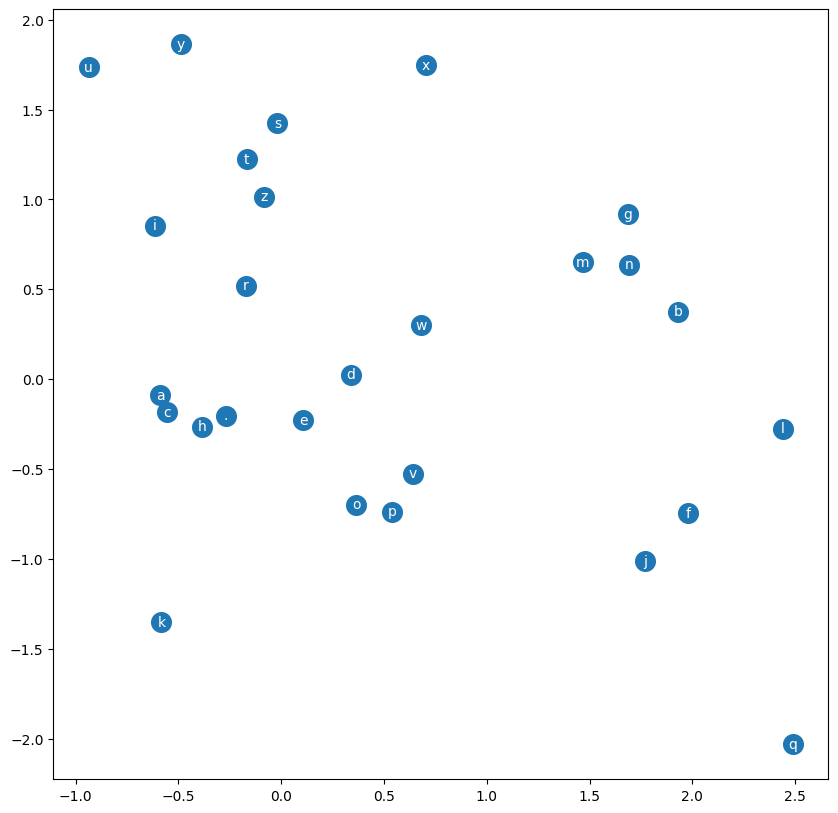

In [31]:
C = parameters[0]
plt.figure(figsize=(10,10))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itoc[i], ha="center", va="center", color="white")


In [32]:
def generator(parameters, amt):
    C, W1, b1, W2, b2 = parameters
    g = torch.Generator().manual_seed(1)
    out = []
    for i in range(amt):
        ix = [0,0,0] # our window is of length 3
        name = ''
        
        while True:
            
            enc = encoder(torch.tensor(ix))
            emb = enc @ C
            h = emb.view((-1, W1.shape[0])) @ W1 + b1
            l1 = activation(h)
            logits = l1 @ W2 + b2
            counts = logits.exp()
            probs = counts / counts.sum(dim=1, keepdim=True)
            next_char_i = torch.multinomial(probs, 1, replacement=True, generator=g)
            next_char = itoc[next_char_i.item()]
            ix.pop(0)
            ix.append(next_char_i)
            name += next_char
            if next_char_i == 0:
                break
        out.append(name)
    return out
names = generator(parameters, 10)
names

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_40959/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


['amari.',
 'garia.',
 'albert.',
 'alissa.',
 'dez.',
 'brylynn.',
 'kestleightan.',
 'maddison.',
 'caeda.',
 'dacelianon.']

In [53]:
def MLP_with_batch_normalization(X, Y, parameters, batch_size, lr, steps=100, print_break=5000):
    token_size = X.shape[1]
    
    C, W1, W2, b2, bngain, bnbias = parameters
    bnmean_running = torch.zeros((1, W1.shape[1]))
    bnstd_running = torch.zeros((1, W1.shape[1]))
    
    for p in parameters:
        p.requires_grad = True
    
    lossi = []
    for i in range(steps):
        # make minibatch
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)

        # forward pass
        emb = X[ix] @ C # X here is X encoded, but since it's one hot encoded, you can also do C[X] where X is the non-encoded tensor of inputs
        h = emb.view((-1, token_size*C.shape[1])) @ W1 #+ b1 now that we have batch normalization, we can see that we end up subtracting this bias when we subtract the mean from h, so this does nothing
        bn_mean = h.mean(0, keepdim=True)
        bn_std = h.std(0, keepdim=True)
        bnmean_running = bnmean_running * 0.999 + bn_mean * 0.001
        bnstd_running = bnstd_running * 0.999 + bn_std * 0.001
        h_normalized = bngain * (h - bn_mean ) / bn_std + bnbias
        l1 = activation(h_normalized)
        logits = l1 @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])
        # backwards pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        for p in parameters:
            p.data += -lr * p.grad
        
        lossi.append(loss)
        if i % print_break == 0:
            print(f"loss at {i}/{steps}: ", loss.item())
    return loss.item(), lossi, bnmean_running, bnstd_running

In [54]:
def forward_pass_with_batch_normalization(encx, parameters, bn_mean, bn_std):
    C, W1, W2, b2, bngain, bnbias = parameters
    
    emb = encx @ C
    h = (emb.view((-1, W1.shape[0])) @ W1) #+ b1)
    h_normalized = bngain * (h + bn_mean) / bn_std + bnbias
    l1 = activation(h_normalized)
    logits = l1 @ W2 + b2
    return logits


def runMLP_with_batch_normalization(encx_train, encx_val, ency_train, ency_val, num_c):
    batch_size = 32
    lr = 10**-1
    steps = 100000
    emb_layer_size = 10
    tanh_layer_size = 200 # hidden layer size
    g = torch.Generator().manual_seed(1)
    C = torch.randn((num_c, emb_layer_size), generator=g)
    W1 = torch.randn((emb_layer_size*encx_train.shape[1], tanh_layer_size), generator=g) * (5/3) /  ((emb_layer_size*encx_train.shape[1])**0.5) # this is basically a kaiming init done manually
    # b1 = torch.randn(tanh_layer_size, generator=g) * 0.01 # with batch normalization, this is no longer needed as it has no effect on the gradient
    W2 = torch.randn((tanh_layer_size, num_c), generator=g) * 0.01  # we want the output in the initial stage to be close to uniform, since all outputs should have an equal chance 
    b2 = torch.randn(num_c, generator=g) * 0 # we want the output in the initial stage to be close to uniform, since all outputs should have an equal chance 
    
    bngain = torch.ones((1, tanh_layer_size))
    bnbias = torch.zeros(1,tanh_layer_size)

    
    parameters = [C, W1 , W2, b2, bngain, bnbias]
    training_loss, training_lossi, bn_mean, bn_std = MLP_with_batch_normalization(encx_train, ency_train, parameters, batch_size, lr, steps, print_break=20000)
    # after training, we can do calculations up to the batch normalization step, and instead of doing the normalization, we get the mean and std from training and store them for use in val and testing
    # with torch.no_grad():
    #     emb = xenc @ C
    #     h = emb.view((-1, W1.shape[0])) @ W1 + b1
    #     # instead of recalculating the mean of h every time we go through a forward pass, we can set it to the values we have after training.
    #     bn_mean = h.mean(0, keepdim=True)
    #     bn_std = h.std(0, keepdim=True)
    print("training loss: ", training_loss)
    # the parameters are passed by reference, which is why they get changed and we don't have to pass them back
    val_logits = forward_pass_with_batch_normalization(encx_val, parameters, bn_mean, bn_std)
    val_loss = F.cross_entropy(val_logits, ency_val).item()
    
    print("val loss: ", val_loss)
    return parameters, training_lossi, bn_mean, bn_std
    
encx = encoder(X)
ency = encoder(Y)
encx_train, encx_val, encx_test  = split(encx, [0.8,0.1,0.1])
ency_train, ency_val, ency_test = split(ency, [0.8,0.1,0.1])
parameters_n, training_n_lossi, bn_mean, bn_std = runMLP_with_batch_normalization(encx_train, encx_val, ency_train, ency_val, num_c)

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_40959/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


loss at 0/100000:  3.2885079383850098
loss at 20000/100000:  2.290764093399048
loss at 40000/100000:  2.458909511566162
loss at 60000/100000:  1.9429562091827393
loss at 80000/100000:  1.905670166015625
training loss:  1.8789650201797485
val loss:  3.196349620819092


In [52]:
def generator_with_batch_norm(parameters_n, bnmean, bnstd, amt=1):
    C, W1, W2, b2, bngain, bnbias = parameters_n
    g = torch.Generator().manual_seed(1)
    out = []
    for i in range(amt):
        ix = [0,0,0] # our window is of length 3
        name = ''
        
        while True:
            
            enc = encoder(torch.tensor(ix))
            emb = enc @ C
            h = emb.view((-1, W1.shape[0])) @ W1
            h_norm = bngain * (h - bnmean) /bnstd + bnbias
            l1 = activation(h_norm)
            logits = l1 @ W2 + b2
            counts = logits.exp()
            probs = counts / counts.sum(dim=1, keepdim=True)
            next_char_i = torch.multinomial(probs, 1, replacement=True, generator=g)
            next_char = itoc[next_char_i.item()]
            ix.pop(0)
            ix.append(next_char_i)
            name += next_char
            if next_char_i == 0:
                break
        out.append(name)
    return out
names = generator_with_batch_norm(parameters_n, bn_mean, bn_std, 10)
names

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_40959/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


['khalexglemargurt.',
 'jarossley.',
 'kambrixlett.',
 'rick.',
 'christum.',
 'zakkynslee.',
 'khadheliston.',
 'jamersh.',
 'zakkylan.',
 'jupton.']